# Exercise 7. K-means Clustering and Principal Component Analysis

In this exercise, you will implement the **K-means** clustering algorithm and
apply it to compress an image. In the second part, you will use principal
component analysis to find a low-dimensional representation of face images.
Before starting on the programming exercise, we strongly recommend watch-
ing the video lectures and completing the review questions for the associated
topics. For details see **ex7.pdf**

We will implement a K-means class **```Kmeans```** mathematical concepts and algorithms without using any ML library then in the following section we will use it in the exercise 7 of the course.

The class is split into multiple cells using **```jdc```** package so that notes can be written for learning and understanding. Complete implementation of the class is under **```src/unsupervised/kmeans.py```** module of this repository.

Following cell declares the class **```Kmeans```** with its basic attributes and common utility members.

In [36]:
import jdc
import numpy as np
import matplotlib.image as im
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import src.utils.displaydata as d

In [37]:
class Kmeans(object):
    '''
    K-means, PCA implementation.
    '''
    def __init__(self, X):
        '''
        Initialize instance parameters.
    
        Arguments:
          X (m x n float matrix): Data matrix.
        '''
        self.X = X
        self.mu = None
        self.sigma = None
        self._colors = None
    
    
    def kmeans_init_centroids(self, K):
        '''
        Initialize and return K centroids that are to
        be used in K-Means on the dataset X.
    
        Arguments:
          K (int): Number of centroids.
    
        Return:
          (K x X.shape[1]) Centroids values.
        '''
        # Initialize the centroids to be random examples.
        # Randomly reorder the indices of examples.
        rand_idx = np.random.permutation(self.X.shape[0])
        # Take the first K examples as centroids
        centroids = self.X[rand_idx[:K],:]
        return centroids
    
    
    def kmeans_showprogress(self, centroids,  iter, 
                                  plt_progress=False):
        '''
        Compute K-Means algorithm and plot progress.
    
        Arguments:
          centroids (m x n float matrix): Centroids values.
          iter (int): Max number of iterations.
          plt_progress (Boolean): 'True' if show progress on the graph.
    
        Returns:
          ci (m x n float matrix): Centroid values.
          cc (int vector): The indices of the closest centroids.
        '''
        K = centroids.shape[0]
        self._colors = cm.rainbow(np.linspace(0, 1, K))
        cc = None
    
        for i in range(iter):
          # For each example in X, assign it to the
          # closest centroid.
          cc = self.closest_centroid(centroids);
    
          if plt_progress:
            self._plot_progress_kmeans(centroids, cc, K, i)
          centroids = self.centroids_means(cc, K)
        return centroids, cc.astype(int)
    
    
    def project_data(self, X_norm, U, K):
        '''
        Project data to 'K' dimensions.
    
        Arguments:
          U (m x n float matrix): Unitary matrices.
          K (int): Number of dimensions.
    
        Return:
          Projected matrix to the 'K' dimensions.
        '''
        Z = np.zeros((X_norm.shape[0], K))
        for i in range(X_norm.shape[0]):
          xi = X_norm[[i],:]
          Z[i,:] = xi.dot(U[:,:K])
        return Z
    
    
    def recover_data(self, Z, U, K):
        '''
        Recover data from 'K' dimension back to
        original dimensions.
    
        Arguments:
          Z (m x n float matrix): Projected dimensions.
          U (m x n float matrix): Unitary matrices.
          K (int): Number of dimensions.
    
        Return:
          Recovered matrix to the original dimensions.
        '''
        X_rec = np.zeros((Z.shape[0], U.shape[0]))
        for i in range(Z.shape[0]):
          zi = Z[[i],:].transpose()
          for j in range(U.shape[0]):
            X_rec[i,j] = zi.transpose().dot((U[[j],:K]).transpose())[0][0]
        return X_rec
    
    
    def plot_data_set(self, X, title_label='', x_label='', y_label=''):
        '''
        Plot data points.
    
        Arguments:
          X (m x n float matrix): Data points.
          title_label (str): Title label.
          x_label (str): X-axis label.
          y_label (str): Y-axis label.
        '''
        plt.title(title_label)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.plot(X[:, 0], X[:, 1], 'bo')
        plt.show()
    
    
    def plot_pca_vector(self, p1, p2, xlim, ylim):
        '''
        Plot PCA vector.
    
        Arguments:
          p1 (float pair): Point 1.
          p2 (float pair): Point 2.
          xlim (float pair): x-axis limit.
          ylim (float pair): y-axis limit.
        '''
        plt.title('Computed eigenvectors of the dataset')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.plot(self.X[:,0], self.X[:,1], 'bo')
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
        plt.show()

    
    def _plot_progress_kmeans(self, centroids, closes_centroids, K, i):
        '''
        Plots kMeans data, 2d only.
    
        Arguments:
          centroids (m x n): Centroids matrix.
          closest_centroids (vector): Closest centroids.
          K (int): Dimensions.
          i (int): Index of iteration.
        '''
        for k, c in zip(list(range(K)), self._colors):
          plt.scatter(self.X[np.where(closes_centroids == k),0], 
                      self.X[np.where(closes_centroids == k),1],
                      15, color=c)
    
        # Plot the centroids as black x's
        plt.plot(centroids[:,0], centroids[:,1],
                 marker='x', color='black')
        plt.title('Iteration number {}'.format(i))
        plt.show()

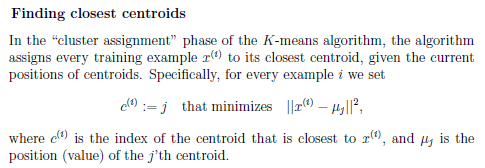

In [38]:
%%add_to Kmeans

def closest_centroid(self, centroids):
    '''
    Compute the closest centroid memberships for every example.

    Arguments:
      centroids (m x n float matrix): Centroid values.

    Return:
      cc (int vector): The indices of the closest centroids.
    '''
    ci = np.zeros((self.X.shape[0], 1))

    for i, xi in enumerate(self.X):
      mod_list = []
      for c in centroids:
        mod_list.append(np.sqrt(np.sum((xi - c) ** 2)))
      ci[i] = np.argmin(mod_list)
    return ci.astype(int)

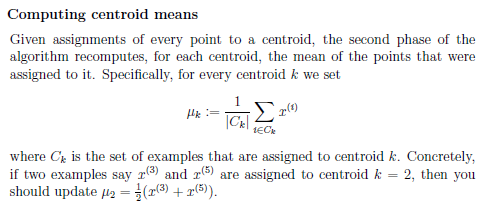

In [39]:
%%add_to Kmeans

def centroids_means(self, ci, K):
    '''
    Compute means based on the closest centroids.

    Computes the new centroids by computing the means
    of the data points assigned to each centroid.

    Arguments:
      ci (int vector): A vector of centroid indices assignments.
      K (int): Number of dimensions.

    Return:
      (m x n float matrix): Mean calculated centroids.
    '''
    m = self.X.shape[0]
    n = self.X.shape[1]
    centroids = np.zeros((K, n))

    for k in range(K):
      xi_idx = np.where(ci[:,0] == k)[0]
      centroids[k,:] = np.sum(self.X[xi_idx,:], axis=0) / len(xi_idx)
    return centroids

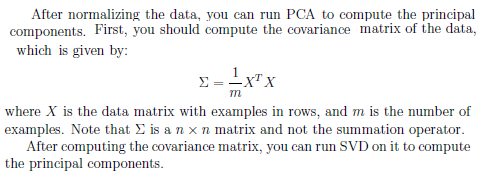

In [40]:
%%add_to Kmeans

def pca(self, norm_first=True):
    '''
    Compute Principal Component Analysis on the dataset X.

    Computes eigenvectors of the covariance matrix of X 
    returns the eigenvectors U, the eigenvalues (on diagonal)
    in s.

    Arguments:
      norm_first (Boolean): 'True' if normalize data before processing.

    Return:
      U, Unitary matrices.
      s, The singular values for every matrix, sorted in descending order.
    '''
    m = self.X.shape[0]
    X_norm = self.X

    # First compute the covariance matrix.
    if norm_first:
      X_norm = self._normalize()
    cov_mat = X_norm.transpose().dot(X_norm) / m

    # Compute the eigenvectors and eigenvalues
    # of the covariance matrix.
    U, s, V  = np.linalg.svd(cov_mat, full_matrices=True)
    return U, s

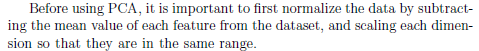

In [41]:
%%add_to Kmeans

def _normalize(self):
    '''
    Normalized version of X where the mean value
    of each feature is 0 and the standard deviation is 1. 
    This is often a good preprocessing step to do when
    working with learning algorithms.
    '''
    #self.mu = np.mean(self.X)
    #self.sigma = np.std(self.X)
    #X_norm = (self.X - self.mu) / self.sigma

    self.mu = np.mean(self.X, axis=0)
    self.sigma = np.std(self.X, axis=0)

    X_norm = np.zeros_like(self.X)
    for j in range(self.X.shape[1]):
      X_norm[:,j] = (self.X[:,j] - self.mu[j]) / self.sigma[j]
    return X_norm

### Course Exercise No 7 'Exercise 7 K-means Clustering and Principal Component Analysis'. For detailed description of the exercise see "ex7.pdf"
#### This exercise uses the class "Kmeans" we implemented above.
#### Solution of whole excercise is available in a single class definitions see ```src/exercises/coursera/ex7.py```

In [42]:
import warnings
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-height: 100% ! important; }</style>"))
warnings.filterwarnings("ignore")


datafname1 = 'data/ex7data1.dat'
datafname2 = 'data/ex7data2.dat'
birdimg_fname = 'data/bird_small.png'
ex7faces = 'data/ex7faces.dat'

## Parts of the exercise related to KMeans

### Part 1: Find Closest Centroids

In [43]:
print('Loading data...')
X = np.loadtxt(datafname2, delimiter=',')

# Select an initial set of centroids
K = 3; # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
print(initial_centroids)

Loading data...
[[3 3]
 [6 2]
 [8 5]]


In [44]:
# Find the closest centroids for the examples using the initial_centroids
km = Kmeans(X)
cc = km.closest_centroid(initial_centroids)
print('The closest centroids should be 0, 2, 1 respectively.')
print('Closest centroids for the first 3 examples. {}, test passed.'.format(cc[:3,0]))

The closest centroids should be 0, 2, 1 respectively.
Closest centroids for the first 3 examples. [0 2 1], test passed.


### Part 2: Compute centroids means

In [45]:
print('The centroids should be about.');
print('[ 2.428301 3.157924 ]');
print('[ 5.813503 2.633656 ]');
print('[ 7.119387 3.616684 ]');

centroids = km.centroids_means(cc, K)
print('Computed centroids, test passed.')
print(centroids)

The centroids should be about.
[ 2.428301 3.157924 ]
[ 5.813503 2.633656 ]
[ 7.119387 3.616684 ]
Computed centroids, test passed.
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


### Part 3: K-Means Clustering

Running K-Means clustering on example dataset.


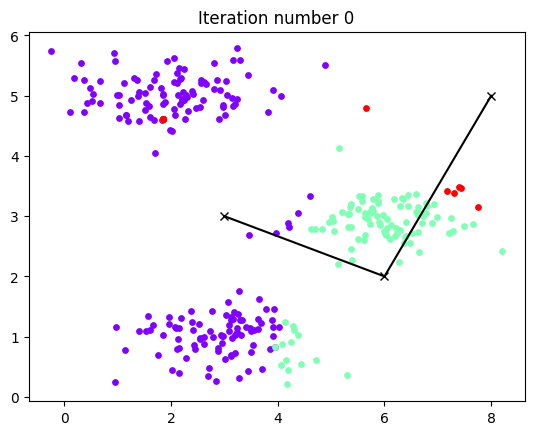

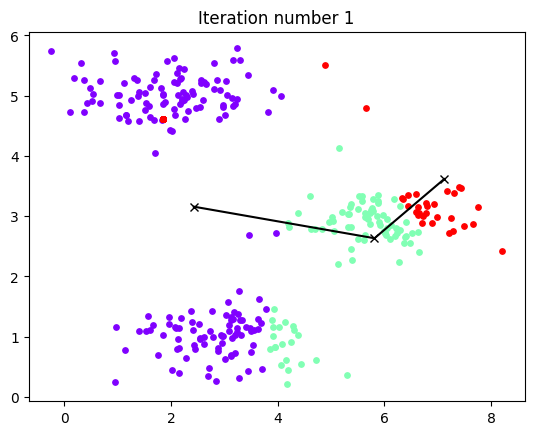

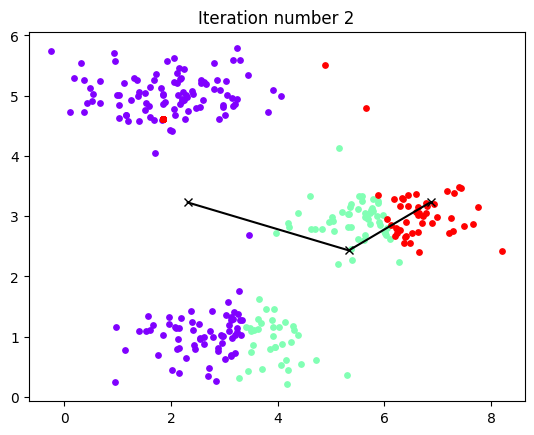

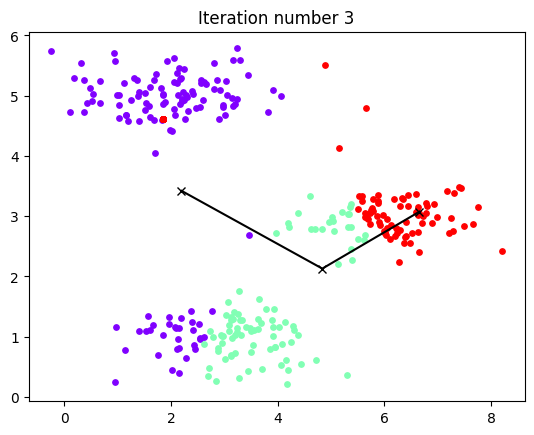

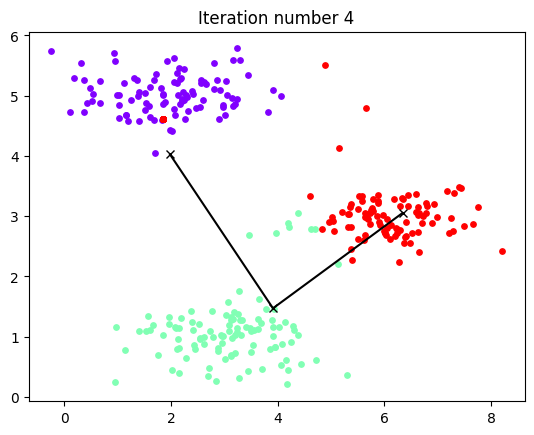

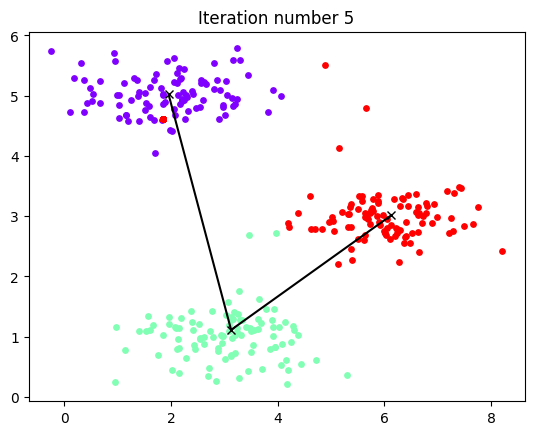

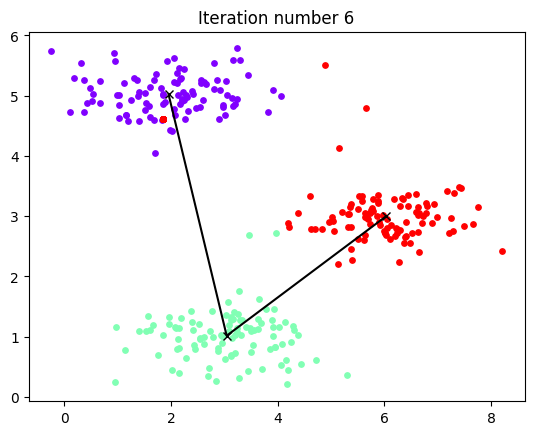

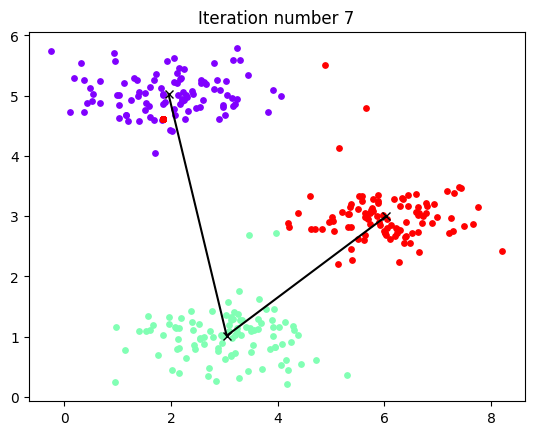

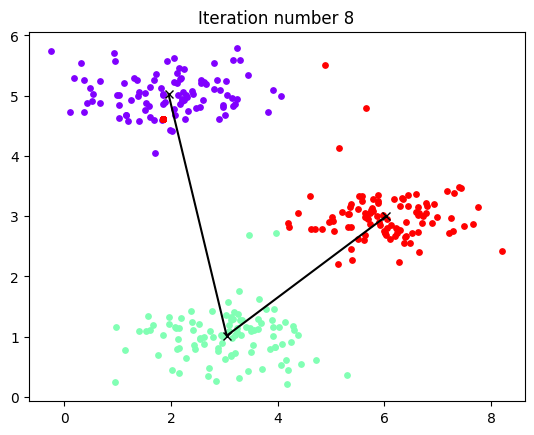

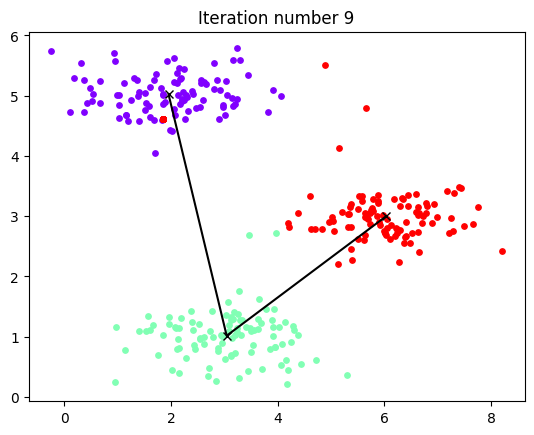

K-Means Done.


In [46]:
print('Running K-Means clustering on example dataset.')
K = 3;
iter = 10;
km.kmeans_showprogress(initial_centroids, iter, True)
print('K-Means Done.')

## Parts of the exercise related to KMeans clustering pixels

### Part 4: K-Means Clustering on Pixels

In [47]:
print('Running K-Means clustering on pixels from an image (small bird image) please wait...')

#  Load an image of a bird
A = im.imread(birdimg_fname)

# Divide by 255 so that all values are in the range 0 - 1.
A = A / 255

# Size of the image
img_size = A.shape

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = np.reshape(A, newshape=(img_size[0] * img_size[1], 3))
K = 16
iter = 10
print('Processing when K={} and max_iter={}.'.format(K, iter))

km_bird = Kmeans(X)
initial_centroids = km_bird.kmeans_init_centroids(K)
centroids = km_bird.kmeans_showprogress(initial_centroids, iter)[0]
print('Final centroids after processing.')
print(centroids)

Running K-Means clustering on pixels from an image (small bird image) please wait...
Processing when K=16 and max_iter=10.
Final centroids after processing.
[[0.00346115 0.00232457 0.00108255]
 [0.00384375 0.0036553  0.00281175]
 [0.00040302 0.0004344  0.00039464]
 [0.00099438 0.00092976 0.00093264]
 [0.00369627 0.00313228 0.00201011]
 [0.00277139 0.00228223 0.00148209]
 [0.00248386 0.00179427 0.00078615]
 [0.00196448 0.00169499 0.0016102 ]
 [0.00027172 0.00029552 0.00025519]
 [0.00163804 0.0012617  0.00094735]
 [0.00291255 0.00285573 0.00301208]
 [0.00220866 0.00216766 0.00239455]
 [0.00379074 0.00374761 0.00338466]
 [0.0037169  0.00316643 0.00269076]
 [0.00323938 0.00273997 0.00182078]
 [0.0006231  0.00063559 0.00060297]]


### Part 5: Image Compression

Applying K-Means to compress an image...


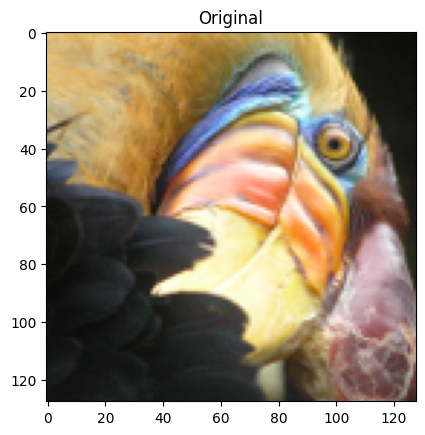

In [48]:
print('Applying K-Means to compress an image...')

# Find closest cluster members
closest_centroids = km_bird.closest_centroid(centroids)

# Essentially, now we have represented the image X as in
# terms of the indices of closest centroids.
# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by it's index in idx) to the centroid value
X_recovered = centroids[closest_centroids[:,0],:]

# Reshape the recovered image into proper dimensions.
X_recovered = np.reshape(X_recovered, newshape=(img_size[0], img_size[1], 3))

# Display the original image .
plt.title('Original')
plt.imshow(A * 255)
plt.show()

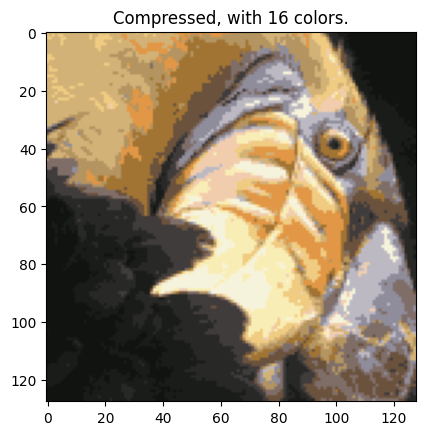

In [49]:
# Display compressed image side by side
plt.title('Compressed, with {} colors.'.format(K))
plt.imshow(X_recovered * 255)
plt.show()

## Parts of the exercise related Principal Component Analysis (PCA)

### Part 1: Load Example Dataset

Visualizing example dataset for PCA...


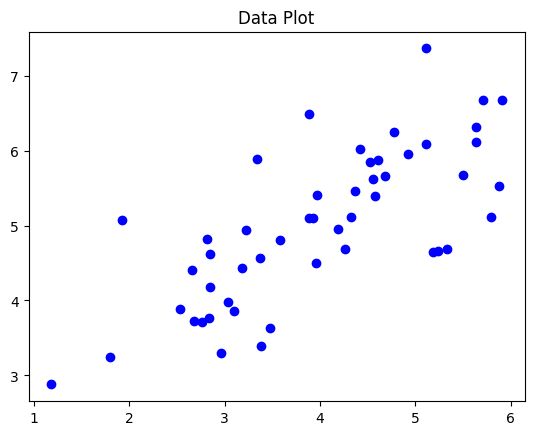

In [50]:
X = np.loadtxt(datafname1, delimiter=',')
print('Visualizing example dataset for PCA...')
km = Kmeans(X)
km.plot_data_set(km.X, 'Data Plot')

### Part 2: Principal Component Analysis

Running PCA on example dataset...


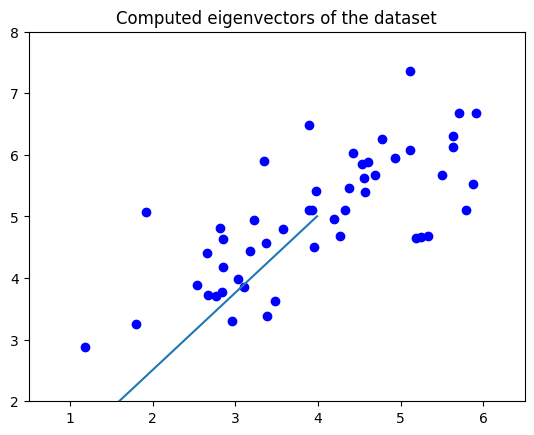

Top eigenvector:
You should expect to see -0.707107 -0.707107.
U[:, 0] = -0.7071067811865476 -0.7071067811865475 test passed.


In [51]:
print('Running PCA on example dataset...')
# Run PCA and before PCA normalize.
U, S = km.pca(True)

xlim = (0.5, 6.5)
ylim = (2, 8)
p1 = km.mu
p2 = km.mu * 1.5 * S[0] * U[:,0]
km.plot_pca_vector(p1, p2, xlim, ylim)

print('Top eigenvector:')
print('You should expect to see -0.707107 -0.707107.')
print('U[:, 0] = {} {} test passed.'.format(U[0,0], U[1,0]))

### Part 3: Dimension Reduction

Dimension reduction on example dataset...


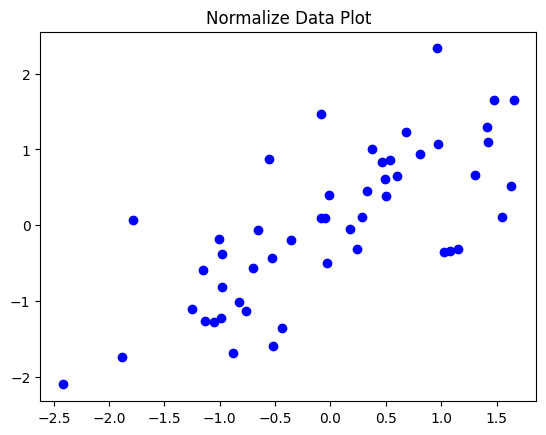

Projecting the data onto K = 1 dimension...
This value should be about 1.481274.
Projection of the first example: 1.4963126084578529 test passed.

Recovering data from the projection...
This value should be about  -1.047419 -1.047419.
Approximation of the first example: -1.0580527922154792 -1.058052792215479 test passed.


In [52]:
print('Dimension reduction on example dataset...')
xlim = (-4, 3)
ylim = (-4, 3)
X_norm = km._normalize()
km.plot_data_set(X_norm, 'Normalize Data Plot')

# Project the data onto K = 1 dimension.
K = 1
Z = km.project_data(X_norm, U, K)
print('Projecting the data onto K = 1 dimension...')
print('This value should be about 1.481274.')
print('Projection of the first example: {} test passed.'.format(Z[0,0]))

X_rec = km.recover_data(Z, U, K)
print('\nRecovering data from the projection...')
print('This value should be about  -1.047419 -1.047419.')
print('Approximation of the first example: {} {} test passed.'.format(X_rec[0,0], X_rec[0,1]))

## Parts of the exercise related Principal Component

### Part 4: Loading and Visualizing Face Data

Loading face dataset...


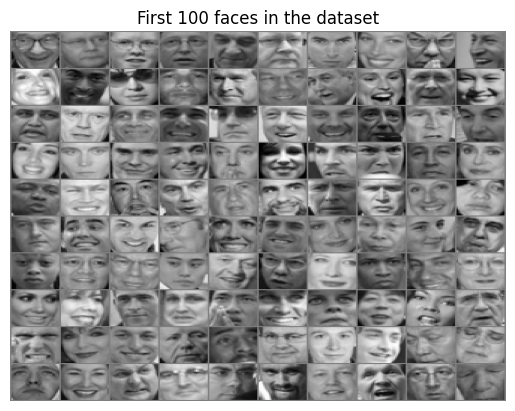

In [53]:
print('Loading face dataset...')
X = np.loadtxt(ex7faces, delimiter=',')

km_faces = Kmeans(X)
# Display the first 100 faces in the dataset.
d.displaydata(X[:100,:], 'First 100 faces in the dataset')

### Part 5: PCA on Face Data: Eigenfaces

Running PCA on face dataset, please wait...


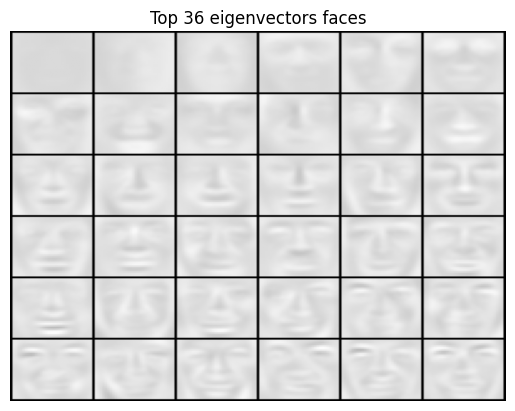

In [54]:
print('Running PCA on face dataset, please wait...')
# Run PCA and before PCA normalize.
U, S = km_faces.pca(True)

#  Visualize the top 36 eigenvectors found
d.displaydata(U[:,:36].transpose(), 'Top 36 eigenvectors faces')

### Part 6: Dimension Reduction for Faces

In [55]:
print('Dimension reduction for face dataset...')
X_norm = km_faces._normalize()

# Project the data onto K = 100 dimension.
K = 100
Z = km_faces.project_data(X_norm, U, K)
print('The projected data Z has a size of: {}'.format(Z.shape))

Dimension reduction for face dataset...
The projected data Z has a size of: (5000, 100)


### Part 7: Visualization of Faces after PCA Dimension Reduction

Original faces...


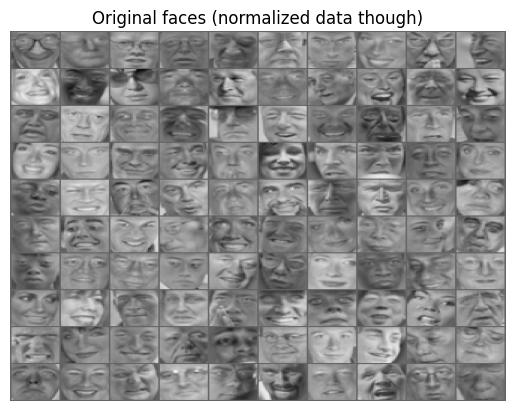

In [56]:
print('Original faces...')
d.displaydata(X_norm[:100,:], 'Original faces (normalized data though)')

Recovering original dimensions, please wait...
Visualizing the projected (reduced dimension) faces...
Recovered faces...


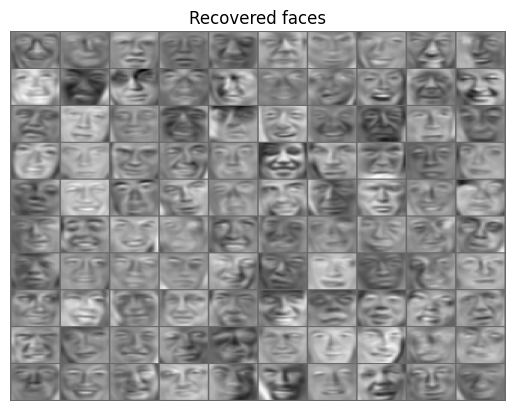

In [57]:
print('Recovering original dimensions, please wait...')
X_rec = km_faces.recover_data(Z, U, K)
print('Visualizing the projected (reduced dimension) faces...')
print('Recovered faces...')
d.displaydata(X_rec[:100,:], 'Recovered faces')